In [1]:
import mesa
import numpy as np
import mesa
import random
import math
import modules as modules
import model as model
import matplotlib.pyplot as plt
import pandas as pd
import optuna

from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector
from mesa.batchrunner import batch_run
import multiprocessing
import os
from scipy.stats import ttest_ind
from scipy.stats import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Collecting data baseline model

In [ ]:
# Example usage:
fixed_params = {
    "property_value_func": modules.property_value_quadrants,
    "income_func": modules.income_func,
    "desirability_func": modules.desirability_func,
    "update_interested_agents_func": modules.update_interested_agents_concurrently,
    "utility_func": modules.utility_func,
    "price_func": modules.price_func,
    "compute_similar_neighbours": modules.compute_similar_neighbours,
    "calculate_gi_star": modules.calculate_gi_star,
    "price_func_cap": modules.price_func_cap,
    "height": 20,
    "width": 20,
    "density": 0.8,
    "minority_pc": 0.2,
    "alpha": 0.5,
    "income_scale": 1.5,
    "property_value_weight": 0.1,
    "mu_theta": 0.8,
    #"sigma_theta": 0.1
}

In [ ]:
variable_params = {
    'sigma_theta': np.linspace(0, 1, 10),
}

In [ ]:
iterations= 1
max_steps = 10
data_collection_period = -1

In [ ]:
results = batch_run(
        model.Schelling,
        parameters={**fixed_params, **variable_params},
        iterations=iterations,
        max_steps=max_steps,
        number_processes=None,
        data_collection_period=data_collection_period,
        display_progress=True
    )

In [ ]:
results

# Added Modules

In [ ]:
def utility_func(model: mesa.Model, agent: mesa.Agent, agent_loc: tuple, property_loc: tuple) -> float:
    
    theta = model.get_theta(agent_loc, model.grid.get_property(property_loc))

    desirability = model.desirability_layer(property_loc)

    alpha = model.alpha

    budget = agent.budget
    
    price = model.price_func(property_loc)
    
    return theta**alpha*desirability**(1-alpha)*((budget-price)/budget)

In [ ]:
def calculate_gi_star(grid, values, x, y, d):
    sum_wx = 0
    sum_w = 0
    sum_wx2 = 0
    n = len(values)

    for (i, j), value in values.items():
        dist = np.sqrt((x - i)**2 + (y - j)**2)
        if dist <= d:
            w = 1  # Binary weight, 1 if within distance threshold
            sum_wx += w * value
            sum_w += w
            sum_wx2 += w * value**2

    mean_x = np.mean(list(values.values()))
    s = np.std(list(values.values()))

    numerator = sum_wx - mean_x * sum_w
    denominator = s * np.sqrt((n * sum_w - sum_w**2) / (n - 1))

    return numerator / denominator if denominator != 0 else 0

In [ ]:
def price_func(model: mesa.Model, property_loc: tuple) -> float:
    
    desirability = model.desirability_layer.data[property_loc]
    property_value = model.property_value_layer.data[property_loc]


    price= (0.5 + desirability) * property_value
    print('price_func applied')
    return price

def price_func_cap(model: mesa.Model, property_loc: tuple, param:float) -> float:
    desirability = model.desirability_layer.data[property_loc]
    property_value = model.property_value_layer.data[property_loc]

    initial_price = property_value

    price= (0.5 + desirability) * property_value

    price_cap = param * initial_price 
    
    if price > price_cap:
        print("price_cap applied")
        return price_cap
    
    return price


# Example usage of plotting hotspot

In [ ]:
def plot_heatmap(data, title="Heatmap"):
    plt.figure(figsize=(10, 8), dpi=300)
    plt.imshow(data, cmap='hot', interpolation='nearest')
    #plt.colorbar()
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label('z-score')
    plt.show()


In [ ]:
# Example of usage after a model run
model = model.Schelling(
     property_value_func=modules.property_value_from_gdf,
     income_func=modules.income_func,
     desirability_func=modules.desirability_func,
     utility_func=modules.utility_func,
     price_func=modules.price_func,
     compute_similar_neighbours=modules.compute_similar_neighbours,
    calculate_gi_star=modules.calculate_gi_star,
    update_interested_agents_func=modules.update_interested_agents_concurrently,
    price_func_cap=modules.price_func_cap,
     height=20,
     width=20,
     #homophily=0.5,
     radius=1,
     density=0.8,
     minority_pc=0.2,
     alpha=0.5,
     seed=42
 )

for i in range(10):
    model.step()
    gi_star_values = model.calculate_hotspots(distance_threshold=3)


#plot_heatmap(gi_star_values, title="Gi* Hotspot Analysis")
#print(model.gi_star_history), optional for now this is muted in the model

# Make animation of desirable hotspots 

In [ ]:
fig, ax = plt.subplots()

def update_heatmap(frame):
    model.step()
    gi_star_values = model.calculate_hotspots(distance_threshold=3)
    ax.clear()
    heatmap = ax.imshow(gi_star_values, cmap='hot', interpolation='nearest')
    ax.set_title(f'Gi* Hotspot Analysis - Step {frame}')
    return heatmap,

ani = animation.FuncAnimation(fig, update_heatmap, frames=30, blit=False)

# Save the animation
ani.save('heatmap_animation_vienna.gif', writer=PillowWriter(fps=2))

plt.show()

# OFAT Analysis

#### Take 5 warm up steps 
#### values chosen; 0.1,0.2,0.3,0.....

# FUNCTIONS TO RUN SENSITIVITY ANALYSIS AND PLOT DATA FROM SENSITIVITY ANALYSIS

In [2]:
def run_sensitivity_analysis(model_class, fixed_params, variable_params, iterations, max_steps, data_collection_period, features_to_analyze, steps_to_skip=5):
    # Perform the batch run with the specified parameters
    results = batch_run(
        model_class,
        parameters={**fixed_params, **variable_params},
        iterations=iterations,
        max_steps=max_steps,
        number_processes=None,
        data_collection_period=data_collection_period,
        display_progress=True
    )
    
    # Convert the results to a DataFrame
    results_df = pd.DataFrame(results)
    
    # Filter out the initial steps to skip
    filtered_results = results_df[results_df['Step'] > steps_to_skip]
    
    # Prepare a dictionary to store the mean and std of the specified features
    analysis_results = {}
    
    # Analyze each feature specified
    for feature in features_to_analyze:
        mean_feature = filtered_results.groupby(list(variable_params.keys()))[feature].mean().reset_index()
        std_feature = filtered_results.groupby(list(variable_params.keys()))[feature].std().reset_index()
        analysis_results[feature] = {
            'mean': mean_feature,
            'std': std_feature
        }
    
    return analysis_results

In [12]:
def plot_feature_analysis(feature_analysis, feature_name, variable_param_name):
    mean_df = feature_analysis[feature_name]['mean']
    std_df = feature_analysis[feature_name]['std']
    
    plt.figure(figsize=(10, 6), dpi=300)
    
    # Plot the mean with standard deviation as error bars
    plt.errorbar(mean_df[variable_param_name], mean_df[feature_name], 
                 yerr=std_df[feature_name], fmt='o', capsize=5, 
                 label=f'Average {feature_name}', color='#63d298ff')
    
    plt.title(f'Average {feature_name} vs {variable_param_name} with Standard Deviation')
    plt.xlabel(variable_param_name)
    #plt.ylim(0,1)
    plt.ylabel(feature_name)
    plt.legend()
    plt.grid(True)
    plt.savefig('diff_singapore_param_entropy_desirable.png')
    plt.show()

In [ ]:
iterations = 100
max_steps = 30

# SIGMA ANALYSIS

In [ ]:

# Example usage:
fixed_params = {
    "property_value_func": modules.property_value_from_gdf,
    "income_func": modules.income_func,
    "desirability_func": modules.desirability_func,
    "update_interested_agents_func": modules.update_interested_agents_concurrently,
    "utility_func": modules.utility_func,
    "price_func": modules.price_func,
    "compute_similar_neighbours": modules.compute_similar_neighbours,
    "calculate_gi_star": modules.calculate_gi_star,
    "price_func_cap": modules.price_func_cap,
    "height": 20,
    "width": 20,
    "policy_singapore_threshold": 0.8,
    "density": 0.8,
    "minority_pc": 0.2,
    "alpha": 0.5,
    "income_scale": 1.5,
    "property_value_weight": 0.35,
    "mu_theta": 0.8,
    #"sigma_theta": 0.1
}

variable_params = {
    'sigma_theta': np.linspace(0, 1, 10),
}

features_to_analyze = ["Utility", "Agent entropy", "Desirability entropy"]

# Run the sensitivity analysis
analysis_sigma_no_policy = run_sensitivity_analysis(
    model_class=model.Schelling,
    fixed_params=fixed_params,
    variable_params=variable_params,
    iterations=iterations,
    max_steps=max_steps,
    data_collection_period=8,
    features_to_analyze=features_to_analyze
)



In [ ]:
analysis_sigma_no_policy_df = pd.DataFrame(analysis_sigma_no_policy)
analysis_sigma_no_policy_df.to_csv('analysis_sigma_no_policy.csv', index=False)

In [ ]:
fixed_params = {
    "property_value_func": modules.property_value_from_gdf,
    "income_func": modules.income_func,
    "desirability_func": modules.desirability_func,
    "update_interested_agents_func": modules.update_interested_agents_concurrently,
    "utility_func": modules.utility_func,
    "price_func": modules.price_func,
    "compute_similar_neighbours": modules.compute_similar_neighbours,
    "calculate_gi_star": modules.calculate_gi_star,
    "price_func_cap": modules.price_func_cap,
    "policy_vienna": True,
    "policy_singapore_threshold": 0.8,
    "height": 20,
    "width": 20,
    "density": 0.8,
    "minority_pc": 0.2,
    "alpha": 0.5,
    "income_scale": 1.5,
    "property_value_weight": 0.35,
    "mu_theta": 0.8,
    #"sigma_theta": 0.3
}

variable_params = {
    'sigma_theta': np.linspace(0, 1, 10),
}

features_to_analyze = ["Utility", "Agent entropy", "Desirability entropy"]

# Run the sensitivity analysis
analysis_sigma_pol_vienna = run_sensitivity_analysis(
    model_class=model.Schelling,
    fixed_params=fixed_params,
    variable_params=variable_params,
    iterations=iterations,
    max_steps=max_steps,
    data_collection_period=8,
    features_to_analyze=features_to_analyze
)

In [ ]:
analysis_sigma_vienna_policy_df = pd.DataFrame(analysis_sigma_pol_vienna)
analysis_sigma_vienna_policy_df.to_csv('analysis_sigma_pol_vienna.csv', index=False)

In [ ]:
fixed_params = {
    "property_value_func": modules.property_value_from_gdf,
    "income_func": modules.income_func,
    "desirability_func": modules.desirability_func,
    "update_interested_agents_func": modules.update_interested_agents_concurrently,
    "utility_func": modules.utility_func,
    "price_func": modules.price_func,
    "compute_similar_neighbours": modules.compute_similar_neighbours,
    "calculate_gi_star": modules.calculate_gi_star,
    "price_func_cap": modules.price_func_cap,
    "policy_singapore": True,
    "policy_singapore_threshold": 0.8,
    "height": 20,
    "width": 20,
    "density": 0.8,
    "minority_pc": 0.2,
    "alpha": 0.5,
    "income_scale": 1.5,
    "property_value_weight": 0.35,
    "mu_theta": 0.8,
    #"sigma_theta": 0.3
}

variable_params = {
    'sigma_theta': np.linspace(0, 1, 10),
}

features_to_analyze = ["Utility", "Agent entropy", "Desirability entropy"]

# Run the sensitivity analysis
analysis_sigma_pol_singa = run_sensitivity_analysis(
    model_class=model.Schelling,
    fixed_params=fixed_params,
    variable_params=variable_params,
    iterations=iterations,
    max_steps=max_steps,
    data_collection_period=8,
    features_to_analyze=features_to_analyze
)

In [ ]:
analysis_sigma_singa_policy_df = pd.DataFrame(analysis_sigma_pol_singa )
analysis_sigma_singa_policy_df.to_csv('analysis_sigma_pol_singa.csv', index=False)

analysis_sigma_vienna_policy_df = pd.DataFrame(analysis_sigma_pol_vienna)
analysis_sigma_vienna_policy_df.to_csv('analysis_sigma_pol_vienna.csv', index=False)

In [ ]:
plot_feature_analysis(analysis_sigma_pol_vienna, "Agent entropy", "sigma_theta")
plot_feature_analysis(analysis_sigma_pol_vienna,"Desirability entropy", "sigma_theta")
plot_feature_analysis(analysis_sigma_pol_vienna, "Utility", "sigma_theta")

In [ ]:
plot_feature_analysis(analysis_sigma_pol_singa, "Agent entropy", "sigma_theta")
plot_feature_analysis(analysis_sigma_pol_singa,"Desirability entropy", "sigma_theta")
plot_feature_analysis(analysis_sigma_pol_singa, "Utility", "sigma_theta")

# ALPHA ANALYSIS

In [ ]:
# Example usage:
fixed_params = {
    "property_value_func": modules.property_value_quadrants,
    "income_func": modules.income_func,
    "desirability_func": modules.desirability_func,
    "update_interested_agents_func": modules.update_interested_agents_concurrently,
    "utility_func": modules.utility_func,
    "price_func": modules.price_func,
    "compute_similar_neighbours": modules.compute_similar_neighbours,
    "calculate_gi_star": modules.calculate_gi_star,
    "price_func_cap": modules.price_func_cap,
    "height": 20,
    "width": 20,
    "density": 0.8,
    "minority_pc": 0.2,
    #"alpha": 0.5,
    "income_scale": 1.5,
    "property_value_weight": 0.1,
    "mu_theta": 0.8,
    "sigma_theta": 0.3
}

variable_params = {
    'alpha': np.linspace(0, 1, 10),
}

features_to_analyze = ["Utility", "Agent entropy", "Desirability entropy"]

# Run the sensitivity analysis
analysis_alpha = run_sensitivity_analysis(
    model_class=model.Schelling,
    fixed_params=fixed_params,
    variable_params=variable_params,
    iterations=iterations,
    max_steps=max_steps,
    data_collection_period=8,
    features_to_analyze=features_to_analyze
)


In [ ]:
analysis_alpha_df = pd.DataFrame(analysis_alpha)
analysis_alpha_df.to_csv('analysis_alpha.csv', index=False)

In [ ]:
plot_feature_analysis(analysis_alpha, "Agent entropy", "alpha")
plot_feature_analysis(analysis_alpha,"Desirability entropy", "alpha")
plot_feature_analysis(analysis_alpha, "Utility", "alpha")

# MINORITY ANALYSIS

In [ ]:
# Example usage:
fixed_params = {
    "property_value_func": modules.property_value_quadrants,
    "income_func": modules.income_func,
    "desirability_func": modules.desirability_func,
    "update_interested_agents_func": modules.update_interested_agents_concurrently,
    "utility_func": modules.utility_func,
    "price_func": modules.price_func,
    "compute_similar_neighbours": modules.compute_similar_neighbours,
    "calculate_gi_star": modules.calculate_gi_star,
    "price_func_cap": modules.price_func_cap,
    "height": 20,
    "width": 20,
    "density": 0.8,
    #"minority_pc": 0.2,
    "alpha": 0.5,
    "income_scale": 1.5,
    "property_value_weight": 0.1,
    "mu_theta": 0.8,
    "sigma_theta": 0.3
}

variable_params = {
    'minority_pc': np.linspace(0, 1, 10),
}

features_to_analyze = ["Utility", "Agent entropy", "Desirability entropy"]

# Run the sensitivity analysis
analysis_minority = run_sensitivity_analysis(
    model_class=model.Schelling,
    fixed_params=fixed_params,
    variable_params=variable_params,
    iterations=iterations,
    max_steps=max_steps,
    data_collection_period=8,
    features_to_analyze=features_to_analyze
)

In [ ]:
analysis_minority_df = pd.DataFrame(analysis_minority)
analysis_minority_df.to_csv('analysis_minority.csv', index=False)

In [ ]:
plot_feature_analysis(analysis_minority , "Agent entropy", "minority_pc")
plot_feature_analysis(analysis_minority ,"Desirability entropy", "minority_pc")
plot_feature_analysis(analysis_minority,  "Utility", "minority_pc")

# MU ANALYSIS

In [ ]:
# Example usage:
fixed_params = {
    "property_value_func": modules.property_value_quadrants,
    "income_func": modules.income_func,
    "desirability_func": modules.desirability_func,
    "update_interested_agents_func": modules.update_interested_agents_concurrently,
    "utility_func": modules.utility_func,
    "price_func": modules.price_func,
    "compute_similar_neighbours": modules.compute_similar_neighbours,
    "calculate_gi_star": modules.calculate_gi_star,
    "price_func_cap": modules.price_func_cap,
    "height": 20,
    "width": 20,
    "density": 0.8,
    "minority_pc": 0.2,
    "alpha": 0.5,
    "income_scale": 1.5,
    "property_value_weight": 0.1,
    #"mu_theta": 0.8,
    "sigma_theta": 0.3
}

variable_params = {
    'mu_theta': np.linspace(0, 1, 10),
}

features_to_analyze = ["Utility", "Agent entropy", "Desirability entropy"]

# Run the sensitivity analysis
analysis_mu = run_sensitivity_analysis(
    model_class=model.Schelling,
    fixed_params=fixed_params,
    variable_params=variable_params,
    iterations=iterations,
    max_steps=max_steps,
    data_collection_period=8,
    features_to_analyze=features_to_analyze
)

In [ ]:
analysis_mu_df = pd.DataFrame(analysis_mu)
analysis_mu_df.to_csv('analysis_mu.csv', index=False)


In [ ]:
plot_feature_analysis(analysis_mu, "Agent entropy", "mu_theta")
plot_feature_analysis(analysis_mu,"Desirability entropy", "mu_theta")
plot_feature_analysis(analysis_mu, "Utility", "mu_theta")

# DENSITY

In [10]:
def plot_feature_analysis_multiple(feature_analyses, feature_name, variable_param_name, labels=None):
    """
    Plots the specified feature from multiple analyses on the same plot with different colors.
    
    Parameters:
    feature_analyses (list of dict): List of feature analysis dictionaries containing 'mean' and 'std' data frames.
    feature_name (str): Name of the feature to plot.
    variable_param_name (str): Name of the variable parameter to plot on the X-axis.
    labels (list of str): List of labels for the analyses. Defaults to None.
    """
    
    plt.figure(figsize=(10, 6), dpi=300)
    colors = ['#63d298ff', '#ff5252ff', '#fff176ff'] # plt.cm.rainbow(np.linspace(0, 1, len(feature_analyses)))
    
    for i, feature_analysis in enumerate(feature_analyses):
        mean_df = feature_analysis[feature_name]['mean']
        std_df = feature_analysis[feature_name]['std']
        label = labels[i] if labels else f"Analysis {i+1}"
        
        # Plot the mean with standard deviation as error bars
        plt.errorbar(mean_df[variable_param_name], mean_df[feature_name], 
                     yerr=std_df[feature_name], fmt='o', capsize=5, 
                     label=label, color=colors[i])
    
    plt.title(f'Average {feature_name} over {variable_param_name}')
    plt.xlabel(variable_param_name)
    plt.ylabel(feature_name)
    plt.legend()
    plt.grid(True)
    #plt.savefig('avarage_desirable_entropy_sigma_diff_policy.png')
    plt.show()

# Example usage:
# Assuming `feature_analyses` is a list of dictionaries with the required structure
# feature_analyses = [analysis1, analysis2, analysis3]
# plot_feature_analysis_multiple(feature_analyses, 'feature_name', 'variable_param_name', labels=['Analysis 1', 'Analysis 2', 'Analysis 3'])

In [ ]:
feature_analyses = [analysis_sigma_pol_singa, analysis_sigma_no_policy,analysis_sigma_pol_vienna]
#plot_feature_analysis_multiple(feature_analyses, 'Utility', 'sigma_theta', labels=['Singapore Policy', 'No Policy', 'Vienna Policy'])
plot_feature_analysis_multiple(feature_analyses, 'Agent entropy', 'sigma_theta', labels=['Singapore Policy', 'No Policy', 'Vienna Policy'])

In [ ]:
plot_feature_analysis_multiple(feature_analyses, 'Agent entropy', 'sigma_theta', labels=['Singapore Policy', 'No Policy', 'Vienna Policy'])

In [ ]:
plot_feature_analysis_multiple(feature_analyses, 'Desirability entropy', 'sigma_theta', labels=['Singapore Policy', 'No Policy', 'Vienna Policy'])

In [ ]:
# Example usage:
fixed_params = {
    "property_value_func": modules.property_value_from_gdf,
    "income_func": modules.income_func,
    "desirability_func": modules.desirability_func,
    "update_interested_agents_func": modules.update_interested_agents_concurrently,
    "utility_func": modules.utility_func,
    "price_func": modules.price_func,
    "compute_similar_neighbours": modules.compute_similar_neighbours,
    "calculate_gi_star": modules.calculate_gi_star,
    "price_func_cap": modules.price_func_cap,
    "height": 20,
    "width": 20,
    #"density": 0.8,
    "policy_singapore_threshold": 0.8,
    "minority_pc": 0.2,
    "alpha": 0.5,
    "income_scale": 1.5,
    "property_value_weight": 0.35,
    "mu_theta": 0.8,
    "sigma_theta": 0.3
}

variable_params = {
    'density': np.linspace(0, 1, 10),
}

features_to_analyze = ["Utility", "Agent entropy", "Desirability entropy"]

# Run the sensitivity analysis
analysis_density = run_sensitivity_analysis(
    model_class=model.Schelling,
    fixed_params=fixed_params,
    variable_params=variable_params,
    iterations=iterations,
    max_steps=max_steps,
    data_collection_period=8,
    features_to_analyze=features_to_analyze
)

In [ ]:
fixed_params = {
    "property_value_func": modules.property_value_from_gdf,
    "income_func": modules.income_func,
    "desirability_func": modules.desirability_func,
    "update_interested_agents_func": modules.update_interested_agents_concurrently,
    "utility_func": modules.utility_func,
    "price_func": modules.price_func,
    "compute_similar_neighbours": modules.compute_similar_neighbours,
    "calculate_gi_star": modules.calculate_gi_star,
    "price_func_cap": modules.price_func_cap,
    "policy_vienna": True,
    "policy_singapore_threshold": 0.8,
    "height": 20,
    "width": 20,
    #"density": 0.8,
    "minority_pc": 0.2,
    "alpha": 0.5,
    "income_scale": 1.5,
    "property_value_weight": 0.35,
    "mu_theta": 0.8,
    "sigma_theta": 0.3
}

variable_params = {
    'density': np.linspace(0, 1, 10),
}

features_to_analyze = ["Utility", "Agent entropy", "Desirability entropy"]

# Run the sensitivity analysis
analysis_density_pol_vienna = run_sensitivity_analysis(
    model_class=model.Schelling,
    fixed_params=fixed_params,
    variable_params=variable_params,
    iterations=iterations,
    max_steps=max_steps,
    data_collection_period=8,
    features_to_analyze=features_to_analyze
)

In [ ]:
fixed_params = {
    "property_value_func": modules.property_value_from_gdf,
    "income_func": modules.income_func,
    "desirability_func": modules.desirability_func,
    "update_interested_agents_func": modules.update_interested_agents_concurrently,
    "utility_func": modules.utility_func,
    "price_func": modules.price_func,
    "compute_similar_neighbours": modules.compute_similar_neighbours,
    "calculate_gi_star": modules.calculate_gi_star,
    "price_func_cap": modules.price_func_cap,
    "policy_singapore": True,
    "policy_singapore_threshold": 0.8,
    "height": 20,
    "width": 20,
    #"density": 0.8,
    "minority_pc": 0.2,
    "alpha": 0.5,
    "income_scale": 1.5,
    "property_value_weight": 0.35,
    "mu_theta": 0.8,
    "sigma_theta": 0.3
}

variable_params = {
    'density': np.linspace(0, 1, 10),
}

features_to_analyze = ["Utility", "Agent entropy", "Desirability entropy"]

# Run the sensitivity analysis
analysis_density_pol_singa = run_sensitivity_analysis(
    model_class=model.Schelling,
    fixed_params=fixed_params,
    variable_params=variable_params,
    iterations=iterations,
    max_steps=max_steps,
    data_collection_period=8,
    features_to_analyze=features_to_analyze
)

In [ ]:
analysis_density_pol_singa

def save_feature_analysis_to_csv(data):
    """
    Save the mean and std DataFrames for each feature in the given data dictionary to separate CSV files.
    
    Parameters:
    data (dict): Dictionary containing feature analysis data with 'mean' and 'std' DataFrames.
    """
    for feature_name, analysis in data.items():
        mean_df = analysis['mean']
        std_df = analysis['std']
        
        # Combine mean and std dataframes
        combined_df = mean_df.copy()
        std_column_name = [col for col in std_df.columns if col != 'density'][0]  # Assuming only one feature column
        combined_df['std'] = std_df[std_column_name]
        
        # Save to CSV
        combined_df.to_csv(f"{feature_name.replace(' ', '_')}_analysis.csv", index=False)
        
# Save each feature analysis to a CSV file
save_feature_analysis_to_csv(analysis_density_pol_singa)

In [ ]:
analysis_density_pol_singa_df  = pd.DataFrame(analysis_density_pol_singa )
analysis_density_pol_singa_df.to_csv('analysis_density_pol_singa.csv', index=False)

In [ ]:
analysis_density_df_no_policy = pd.DataFrame(analysis_density)
analysis_density_df_no_policy.to_csv('analysis_densit_no_pol.csv', index=False)

In [ ]:
analysis_density_policy_vienna_df = pd.DataFrame(analysis_density_pol_vienna)
analysis_density_policy_vienna_df.to_csv('analysis_density_pol_vienna.csv', index=False)

In [ ]:
# Example usage:
# Assuming `feature_analyses` is a list of dictionaries with the required structure
feature_analyses = [analysis_density_pol_singa, analysis_density, analysis_density_pol_vienna]
plot_feature_analysis_multiple(feature_analyses, 'Agent entropy', 'density', labels=['Singapore policy', 'No policy','Vienna policy'])
#plt.savefig('agent_entropy_diff_policy.png')

In [ ]:
plot_feature_analysis_multiple(feature_analyses, 'Desirability entropy', 'density', labels=['Singapore policy', 'No policy','Vienna policy'])

In [ ]:
plot_feature_analysis_multiple(feature_analyses, 'Utility', 'density', labels=['Singapore policy', 'No policy','Vienna policy'])

In [ ]:
plot_feature_analysis(analysis_density_pol_singa_df, "Agent entropy", "density")
plot_feature_analysis(analysis_density_pol_singa_df,"Desirability entropy", "density")
plot_feature_analysis(analysis_density_pol_singa_df, "Utility", "density")

# change in singapore policy value

In [6]:
iterations=100
max_steps=30

In [7]:
fixed_params = {
    "property_value_func": modules.property_value_from_gdf,
    "income_func": modules.income_func,
    "desirability_func": modules.desirability_func,
    "update_interested_agents_func": modules.update_interested_agents_concurrently,
    "utility_func": modules.utility_func,
    "price_func": modules.price_func,
    "compute_similar_neighbours": modules.compute_similar_neighbours,
    "calculate_gi_star": modules.calculate_gi_star,
    "price_func_cap": modules.price_func_cap,
    "policy_singapore": True,
    #"policy_singapore_threshold": 0.8,
    "height": 20,
    "width": 20,
    "density": 0.8,
    "minority_pc": 0.2,
    "alpha": 0.5,
    "income_scale": 1.5,
    "property_value_weight": 0.35,
    "mu_theta": 0.8,
    "sigma_theta": 0.3
}

variable_params = {
    'policy_singapore_threshold': np.linspace(0.7, 1, 10),
}

features_to_analyze = ["Utility", "Agent entropy", "Desirability entropy"]

# Run the sensitivity analysis
analysis_pol_singa_treshold = run_sensitivity_analysis(
    model_class=model.Schelling,
    fixed_params=fixed_params,
    variable_params=variable_params,
    iterations=iterations,
    max_steps=max_steps,
    data_collection_period=8,
    features_to_analyze=features_to_analyze
)

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/carokluin/Documents/CSM/Agent-Based-modelling/ABM_assignment.py/Mesa Schelling Visualization/modules.py:67: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  layer = mesa.space.PropertyLayer(name, width, height, 0)
/Users/carokluin/Documents/CSM/Agent-Based-modelling/ABM_assignment.py/Mesa Schelling Visualization/modules.py:67: FutureWarning: The new PropertyLayer and _PropertyGrid classes experimental. It may be changed or removed in any and all future releases, including patch releases.
We would love to hear what you think about this new feature. If you have any thoughts, share them with us here: https://github.com/projectmesa/mesa/discussions/1932
  layer = mesa.space.PropertyLayer(name, width, height, 0)
/Users/carokluin/Documents/CSM/Agent-Based-modelling/ABM_assignment.py/Mesa Schelling Visualization/modules.py:67: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  layer = mesa.space.PropertyLayer(name, wid

In [ ]:
analysis_pol_singa_treshold_df  = pd.DataFrame(analysis_pol_singa_treshold)
analysis_pol_singa_treshold_df.to_csv('analysis_pol_singa_treshold.csv', index=False)

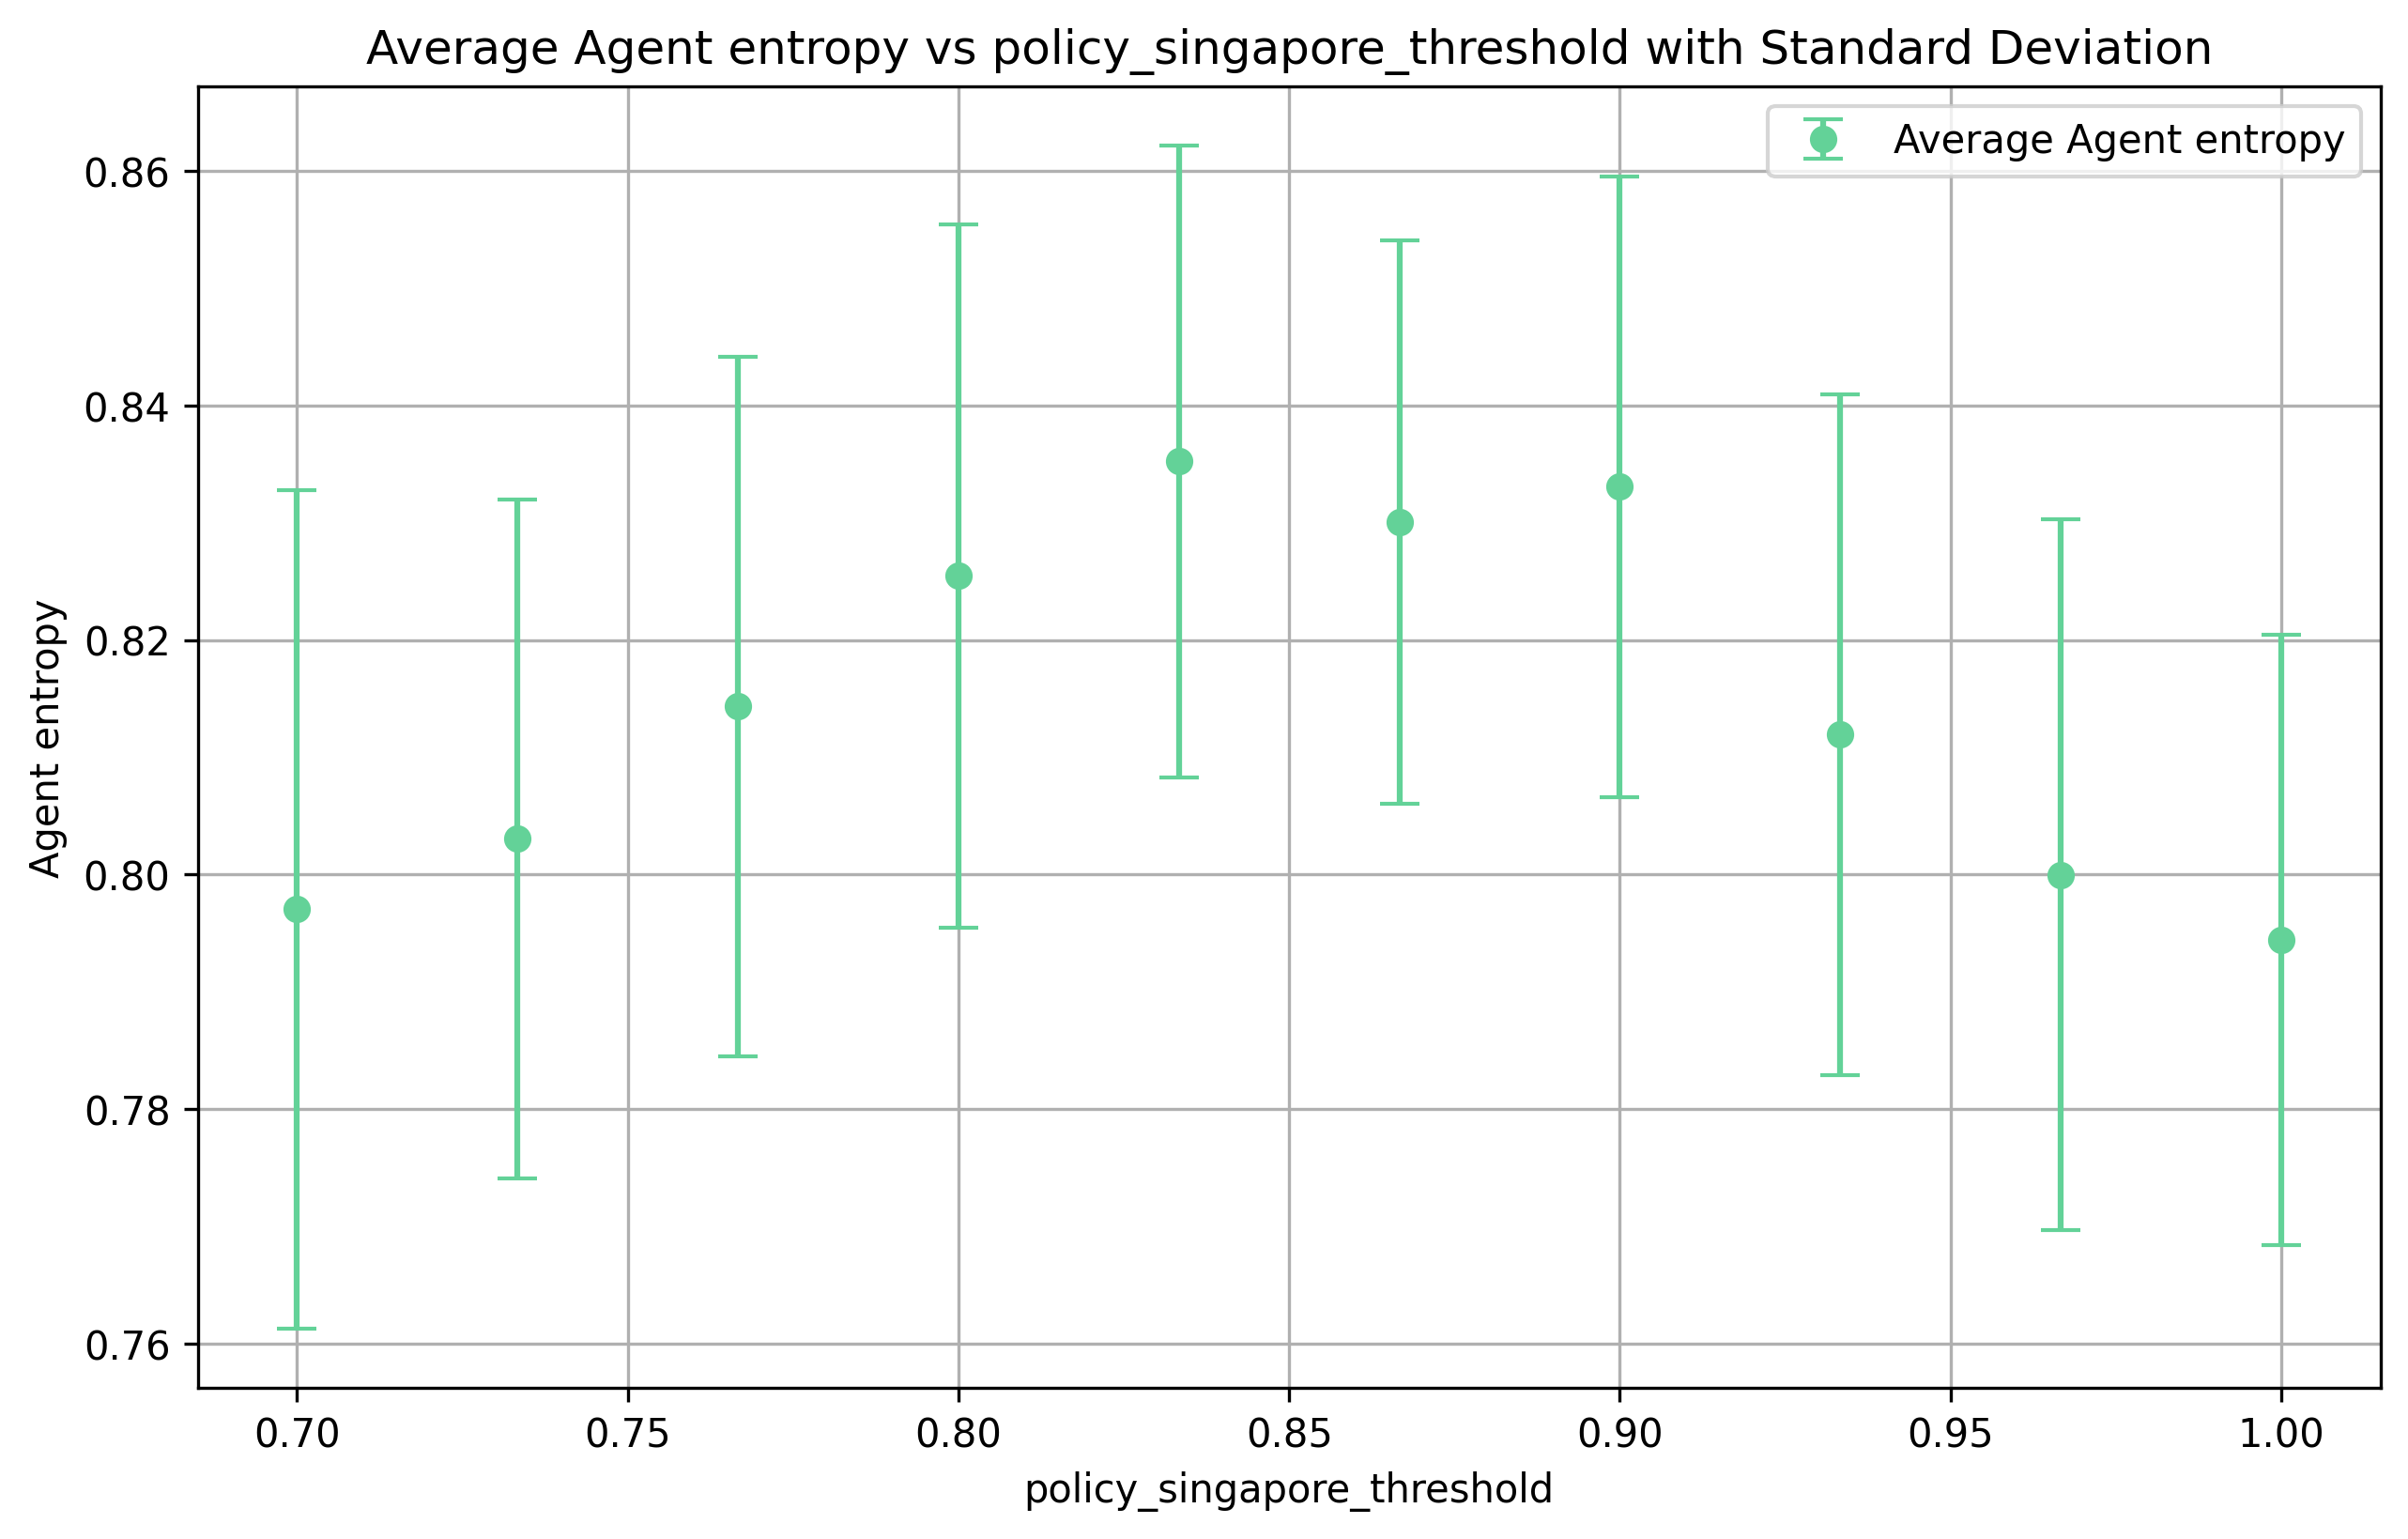

In [13]:
plot_feature_analysis(analysis_pol_singa_treshold, "Agent entropy", "policy_singapore_threshold")

In [ ]:
plot_feature_analysis(analysis_pol_singa_treshold, "Desirability entropy", "policy_singapore_threshold")

In [ ]:
plot_feature_analysis(analysis_pol_singa_treshold, "Utility", "policy_singapore_threshold")

# Change parameters Vienna policy

In [ ]:
fixed_params = {
    "property_value_func": modules.property_value_from_gdf,
    "income_func": modules.income_func,
    "desirability_func": modules.desirability_func,
    "update_interested_agents_func": modules.update_interested_agents_concurrently,
    "utility_func": modules.utility_func,
    "price_func": modules.price_func,
    "compute_similar_neighbours": modules.compute_similar_neighbours,
    "calculate_gi_star": modules.calculate_gi_star,
    "price_func_cap": modules.price_func_cap,
    "policy_vienna": True,
    "policy_singapore": False,
    "policy_singapore_threshold": 0.8,
    "height": 20,
    "width": 20,
    "density": 0.8,
    "minority_pc": 0.2,
    "alpha": 0.5,
    "income_scale": 1.5,
    "property_value_weight": 0.35,
    "mu_theta": 0.8,
    "sigma_theta": 0.3
}

variable_params = {
    'param_try': np.linspace(1.1, 2, 10),
}

features_to_analyze = ["Utility", "Agent entropy", "Desirability entropy"]

# Run the sensitivity analysis
analysis_pol_vienna_cap = run_sensitivity_analysis(
    model_class=model.Schelling,
    fixed_params=fixed_params,
    variable_params=variable_params,
    iterations=iterations,
    max_steps=max_steps,
    data_collection_period=8,
    features_to_analyze=features_to_analyze
)

In [ ]:
analysis_pol_vienna_cap_df  = pd.DataFrame(analysis_pol_vienna_cap)
analysis_pol_vienna_cap_df.to_csv('analysis_pol_vienna_cap.csv', index=False)

In [ ]:
plot_feature_analysis(analysis_pol_vienna_cap, "Utility", "param_try")

In [ ]:
plot_feature_analysis(analysis_pol_vienna_cap, "Desirability entropy", "param_try")

In [ ]:
plot_feature_analysis(analysis_pol_vienna_cap, "Agent entropy", "param_try")

# PROPERTY VALUE WEIGHT

In [ ]:
# Example usage:
fixed_params = {
    "property_value_func": modules.property_value_quadrants,
    "income_func": modules.income_func,
    "desirability_func": modules.desirability_func,
    "update_interested_agents_func": modules.update_interested_agents_concurrently,
    "utility_func": modules.utility_func,
    "price_func": modules.price_func,
    "compute_similar_neighbours": modules.compute_similar_neighbours,
    "calculate_gi_star": modules.calculate_gi_star,
    "price_func_cap": modules.price_func_cap,
    "height": 20,
    "width": 20,
    "density": 0.8,
    "minority_pc": 0.2,
    "alpha": 0.5,
    "income_scale": 1.5,
    #"property_value_weight": 0.1,
    "mu_theta": 0.8,
    "sigma_theta": 0.1
}

variable_params = {
    'property_value_weight': np.linspace(0, 1, 10),
}

features_to_analyze = ["Utility", "Agent entropy", "Desirability entropy"]

# Run the sensitivity analysis
analysis_prop_weight = run_sensitivity_analysis(
    model_class=model.Schelling,
    fixed_params=fixed_params,
    variable_params=variable_params,
    iterations=iterations,
    max_steps=max_steps,
    data_collection_period=8,
    features_to_analyze=features_to_analyze
)



In [ ]:
analysis_prop_weight_df = pd.DataFrame(analysis_prop_weight)
analysis_prop_weight_df.to_csv('analysis_prop_weight.csv', index=False)

In [ ]:
plot_feature_analysis(analysis_prop_weight, "Agent entropy", "property_value_weight")
plot_feature_analysis(analysis_prop_weight,"Desirability entropy", "property_value_weight")
plot_feature_analysis(analysis_prop_weight, "Utility", "property_value_weight")

# Collecting Data Vienna policy

In [ ]:
import modules as modules
import model as model
from model import Schelling

def schelling_vienna(num_runs, num_steps, burn_in_period, minority_pc, property_value_weight, alpha, mu_theta, sigma_theta, density):

    # initialize storage for parameters
    overall_desirability_entropy = []
    overall_agent_entropy = []
    overall_utility = []

    # run the model several times for the same parameter setting 
    for _ in range(num_runs):

        # initialize model
        models = Schelling(
            property_value_func=modules.property_value_quadrants,
            income_func=modules.income_func,
            desirability_func=modules.desirability_func,
            utility_func=modules.utility_func,
            price_func=modules.price_func,
            compute_similar_neighbours=modules.compute_similar_neighbours,
            calculate_gi_star = modules.calculate_gi_star,
            update_interested_agents_func = modules.update_interested_agents_concurrently,
            price_func_cap=modules.price_func_cap,
            policy_vienna=False,
            policy_singapore=True,
            #height=20,
            #width=20,
            radius=1,
            density=density,
            minority_pc=minority_pc,
            alpha=alpha,
            income_scale=1.5, # the scale by which the income is higher than the property value
            property_value_weight=property_value_weight,
            mu_theta = mu_theta,
            sigma_theta = sigma_theta,
            seed=42)

        # Run the model for a certain number of steps
        for _ in range(num_steps):
            models.step()

        # call necessary data collectors
        agent_data = models.datacollector.get_agent_vars_dataframe()
        model_data_entropy = models.datacollector.get_model_vars_dataframe()
    
        # Compute mean and standard deviation of entropies over time per run
        desirability_entropy = model_data_entropy['Desirability entropy'].to_numpy()
        # desirability_entropy_std = model_data_entropy['Desirability entropy'].std()
        mean_desirability_entropy = np.mean(desirability_entropy[burn_in_period::])
        
        agent_entropy = model_data_entropy['Agent entropy'].to_numpy()
        # agent_entropy_std = model_data_entropy['Agent entropy'].std()
        mean_agent_entropy = np.mean(agent_entropy[burn_in_period::])
        
        # Compute mean and standard deviation of utility per time step over each agent 
        utility_mean = agent_data.groupby(level='Step')['Utility'].mean()
        utility_std = agent_data.groupby(level='Step')['Utility'].std()
        
        # Compute mean and standard deviation of utility over time 
        utility_mean = pd.DataFrame(utility_mean).to_numpy()
        utility_std = pd.DataFrame(utility_std).to_numpy()
        mean_utility_interim = np.mean(utility_mean[burn_in_period::])

        # Append all results to storage
        overall_desirability_entropy.append(mean_desirability_entropy)
        overall_agent_entropy.append(mean_agent_entropy)
        overall_utility.append(mean_utility_interim)

    return np.array(overall_desirability_entropy), np.array(overall_agent_entropy), np.array(overall_utility)

In [ ]:
minority_pc, property_value_weight, alpha, mu_theta, sigma_theta, density = 0.3, 0.1, 0.5, 0.8, 0.1, 0.8

In [ ]:
overall_desirability_entropy,overall_agent_entropy,overall_utility= schelling_vienna(100, 30, 5, minority_pc, property_value_weight, alpha, mu_theta, sigma_theta, density)

In [ ]:
singapore_initial_results = np.column_stack((overall_desirability_entropy, overall_agent_entropy, overall_utility))

# Save the stacked array to a CSV file
np.savetxt('singapore_policy_100_runs.csv', singapore_initial_results, delimiter=',', header='desirability_entropy, agent_entropy, utility')

# ANOVA of results from different policies and control

In [ ]:
# Load the data from CSV files
data_vienna_policy = pd.read_csv("/Users/carokluin/Documents/CSM/Agent-Based-modelling/ABM_assignment.py/Mesa Schelling Visualization/vienna_policy_100_runs.csv")
data_singapore_policy = pd.read_csv("/Users/carokluin/Documents/CSM/Agent-Based-modelling/ABM_assignment.py/Mesa Schelling Visualization/singapore_policy_100_runs.csv")
data_no_policy = pd.read_csv("/Users/carokluin/Documents/CSM/Agent-Based-modelling/ABM_assignment.py/Mesa Schelling Visualization/no_policy_result.csv")

data_vienna_policy.columns = data_vienna_policy.columns.str.strip()
data_no_policy.columns = data_no_policy.columns.str.strip()
data_singapore_policy.columns = data_singapore_policy.columns.str.strip()

# Metrics to compare
metrics = ["# desirability_entropy", "agent_entropy", "utility"]


In [ ]:
# Prepare data for ANOVA
data_combined = pd.concat([data_vienna_policy.assign(policy='Vienna'),
                           data_singapore_policy.assign(policy='Singapore'),
                           data_no_policy.assign(policy='No Policy')])

# Function to perform ANOVA
def perform_anova(metric):
    groups = data_combined.groupby('policy')[metric].apply(list)
    f_stat, p_value = stats.f_oneway(*groups)
    print(f"ANOVA result for {metric}:")
    print(f"F-statistic: {f_stat:.2f}")
    print(f"P-value: {p_value:.4f}\n")
    return p_value

# Metrics to compare
metrics = ["# desirability_entropy", "agent_entropy", "utility"]

# Perform ANOVA for each metric
anova_results = {metric: perform_anova(metric) for metric in metrics}

In [ ]:

# Function to perform Tukey's HSD test
def perform_tukey(metric):
    tukey = pairwise_tukeyhsd(endog=data_combined[metric], 
                              groups=data_combined['policy'], 
                              alpha=0.05)
    print(f"Tukey's HSD test result for {metric}:\n")
    print(tukey)
    print("\n")

# Perform Tukey's HSD test for each metric where ANOVA was significant
for metric in metrics:
    if anova_results[metric] < 0.05:
        perform_tukey(metric)